In [199]:
"""CS231n: Linear Classification 
"""

import numpy as np
import matplotlib.pyplot as plt
import pickle, os, random
from collections import Counter
from ipywidgets import interact, IntSlider, Dropdown
from sklearn.datasets import make_moons, make_circles, make_blobs

In [200]:
# CIFAR-10 Loading Utilities

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        # reshape to (N, C, H, W) then transpose to (N, H, W, C) for channel-last format
        X = X.reshape(10000, 3, 32, 32).astype("float").transpose(0, 2, 3, 1)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(folder_path):
    xs, ys = [], []
    for b in range(1, 6):
        f = os.path.join(folder_path, f'data_batch_{b}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_batch(os.path.join(folder_path, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

X_train, y_train, X_test, y_test = load_CIFAR10('../cifar-10-batches-py')

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [201]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [202]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


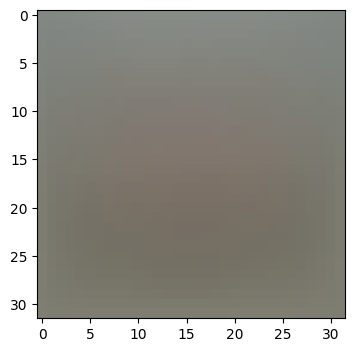

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [203]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [204]:
# Loss Function Definitions

def scores(X, W):
    """
    Compute the scores given the data and weights.
    - X is the data matrix where each row is a data point.
    - W is the weight matrix.
    Returns the scores matrix.
    """
    return W @ X.T

def L_i(x, y, W):
  """
  unvectorized version. Compute the multiclass svm loss for a single example (x,y)
  - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
    with an appended bias dimension in the 3073-rd position (i.e. bias trick)
  - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
  - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
  """
  delta = 1.0 # see notes about delta later in this section
  scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
  correct_class_score = scores[y]
  D = W.shape[0] # number of classes, e.g. 10
  loss_i = 0.0
  for j in range(D): # iterate over all wrong classes
    if j == y:
      # skip for the true class to only loop over incorrect classes
      continue
    # accumulate loss for the i-th example
    loss_i += max(0, scores[j] - correct_class_score + delta)
  return scores, loss_i

def L_i_vectorized(x, y, W):
  """
  A faster half-vectorized implementation. half-vectorized
  refers to the fact that for a single example the implementation contains
  no for loops, but there is still one loop over the examples (outside this function)
  """
  delta = 1.0
  scores = W.dot(x)
  # compute the margins for all classes in one vector operation
  margins = np.maximum(0, scores - scores[y] + delta)
  # on y-th position scores[y] - scores[y] canceled and gave delta. We want
  # to ignore the y-th position and only consider margin on max wrong class
  margins[y] = 0
  loss_i = np.sum(margins)
  return scores, loss_i

def L(X, y, W):
  """
  fully-vectorized implementation :
  - X holds all the training examples as columns (e.g. 3073 x 50,000 in CIFAR-10)
  - y is array of integers specifying correct class (e.g. 50,000-D array)
  - W are weights (e.g. 10 x 3073)
  """
  # evaluate loss over all examples in X without using any for loops
  # left as exercise to reader in the assignment
  delta = 1.0
  scores = scores(X, W)  # shape (C, N)
  correct_class_scores = scores[y, np.arange(X.shape[0])]  # shape (N,)
  margins = np.maximum(0, correct_class_scores - scores + delta)  # shape (C, N)
  margins[y, np.arange(X.shape[0])] = 0  # zero out correct class margins
  loss = np.sum(margins)
  return scores, loss

  

In [205]:
# example to test loss function

W = np.array([[0.2, -0.5, 0.1, 2.0, 1.1],
     [1.5, 1.3, 2.1, 0.0, 3.2],
     [0.0, 0.25, 0.2, -0.3, -1.2]])
print('Weight matrix W (with bias trick):\n', W)
X = np.array([56, 231, 24, 2, 1])
print('Data point X:\n', X)

score = scores(X, W)
print('Scores (score function):\n', score)
# loss for each class with correct class 0
_ , loss_0 = L_i_vectorized(X, 0, W)
print('Loss (correct class 0): ', loss_0)
_ , loss_1 = L_i_vectorized(X, 1, W)
print('Loss (correct class 1): ', loss_1)
sc, loss_2 = L_i_vectorized(X, 2, W)
print('Loss (correct class 2): ', loss_2)
# double check scores are the same as those computed inside loss function
print('Scores (computed inside loss function):', sc)


Weight matrix W (with bias trick):
 [[ 0.2  -0.5   0.1   2.    1.1 ]
 [ 1.5   1.3   2.1   0.    3.2 ]
 [ 0.    0.25  0.2  -0.3  -1.2 ]]
Data point X:
 [ 56 231  24   2   1]
Scores (score function):
 [-96.8  437.9   60.75]
Loss (correct class 0):  694.25
Loss (correct class 1):  0.0
Loss (correct class 2):  378.15000000000003
Scores (computed inside loss function): [-96.8  437.9   60.75]


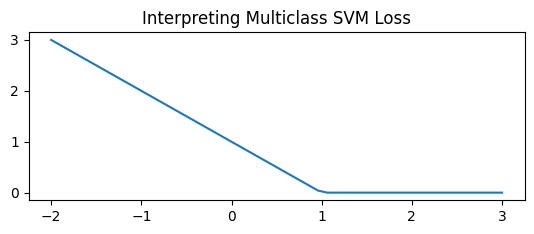

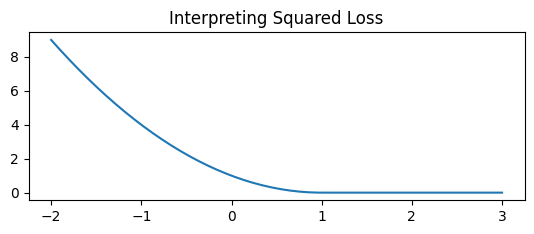

In [206]:
# plotting score differences

plt.subplot(211)
sample_score_diff = np.linspace(-2, 3, 50)
sample_losses = np.maximum(0, - sample_score_diff + 1)  # hinge (svm) loss
plt.plot(sample_score_diff, sample_losses)
plt.title('Interpreting Multiclass SVM Loss')
plt.show()

# if we use a quadratic loss instead
sample_losses_quad = (np.maximum(0, - sample_score_diff + 1))**2  # squared hinge loss
plt.subplot(212)
plt.plot(sample_score_diff, sample_losses_quad)
plt.title('Interpreting Squared Loss')
plt.show()

In [207]:
# Softmax Loss

def softmax_loss(scores, y, base_10=False):
  """
    Compute the softmax loss and probabilities.
    Inputs:
    - scores: Input data, of shape (C, N) where scores[i, j] is the score for class i and example j
    - y: Array of integers specifying the correct class for each example, of shape (N,)
  """
  # scores - unnormalized log probabilities, shape (C, N)
  # exp so that the scores are all positive
  exp_scores = np.exp(scores - np.max(scores, axis=0))  # unnormalized probabilities
  # normalize to get probabilities
  probs = exp_scores / np.sum(exp_scores, axis=0) # probabilities
  # compute loss
  N = scores.shape[1]
  if base_10:
    loss = -np.sum(np.log10(probs[y, np.arange(N)])) / N
  else:
    loss = -np.sum(np.log(probs[y, np.arange(N)])) / N
  return loss, probs

# example to test softmax loss function
sm_score = np.array([[3.2, 5.1, -1.7]]).T  # shape (3, 1)
print('Softmax scores:\n', sm_score)
y = np.array([0])  # correct class
loss, probs = softmax_loss(sm_score, y)
print('Softmax probabilities:\n', probs.round(2))
print('Softmax loss: ', loss)

Softmax scores:
 [[ 3.2]
 [ 5.1]
 [-1.7]]
Softmax probabilities:
 [[0.13]
 [0.87]
 [0.  ]]
Softmax loss:  2.0403551528001698


In [208]:
# Softmax vs SVM Loss Comparison

W1 = np.array(
    [[0.01, -0.05, 0.1, 0.05, 0.0],
     [0.7, 0.2, 0.05, 0.16, 0.2], 
     [0.0, -0.45, -0.2, 0.03, -0.3]])
x1 = np.array([-15, 22, -44, 56, 1]) 
scores1 = scores(x1, W1)  # shape (C, 1)
# print(scores1.shape)
print('Scores:\n', scores1)
y1 = 2  # correct class
svm_loss1 = L_i_vectorized(x1, y1, W1)
print('SVM Loss: ', svm_loss1[1].round(2))
scores1 = scores1.reshape(-1, 1)
# print(scores1.shape)
# print(scores1)
loss1, probs1 = softmax_loss(scores1, np.array([y1]), base_10=True)
print('Probabilities: ', probs1)
print('Softmax Loss: ', loss1.round(3))



Scores:
 [-2.85  0.86  0.28]
SVM Loss:  1.58
Probabilities:  [[0.01544932]
 [0.63116335]
 [0.35338733]]
Softmax Loss:  0.452


In [209]:
# Softmax Gradient

def softmax_loss_gradient(X, y, W, reg = 0.000005):
    """
    Compute the gradient of the softmax loss function with respect to weights W.
    Inputs:
    - X: Input data, of shape (N, D) where each X[i] is a training sample.
    - y: Array of integers specifying the correct class for each example, of shape (N,)
    - W: Weights, of shape (C, D)
    - reg: (float) regularization strength
    Returns:
    - dW: Gradient of the loss with respect to W, of shape (C, D)
    """
    num_train = X.shape[0]
    # Compute scores
    scores = W @ X.T  # shape (C, N)
    # Compute softmax probabilities
    exp_scores = np.exp(scores - np.max(scores, axis=0))  # shape (C, N)
    probs = exp_scores / np.sum(exp_scores, axis=0)       # shape (C, N)
    loss = -np.sum(np.log(probs[y, np.arange(num_train)])) / num_train
    loss += reg * np.sum(W**2)  # regularization term
    # Compute the gradient
    dScores = probs.copy()                                 # shape (C, N)
    dScores[y, np.arange(num_train)] -= 1                  # shape (C, N)
    dScores /= num_train 
    dW = dScores @ X                                     # shape (C, D)
    # Regularization gradient
    dW += 2 * reg * W
    return loss, dW

In [210]:
# Linear Classifier

class LinearClassifier(object):
    def __init__(self):
        self.W = None
    
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c means
          that X[i] has label c, where 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        Returns:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(num_classes, dim)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their corresponding labels to use in this round of gradient descent.
            indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[indices]
            y_batch = y[indices]

            # evaluate loss and gradient
            loss, grad = softmax_loss_gradient(X_batch, y_batch, self.W, reg)
            loss_history.append(loss)

            # perform parameter update
            self.W -= learning_rate * grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history
    
    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        scores = self.W @ X.T  # shape (C, N)
        y_pred = np.argmax(scores, axis=0)  # shape (N,)
        return y_pred
    
    def loss(self, X, y, reg):
        pass # loss function defined outside the class

class Softmax(LinearClassifier):
    def loss(self, X, y, reg):
        return softmax_loss_gradient(X, y, self.W, reg)

iteration 0 / 1500: loss 777.642372
iteration 100 / 1500: loss 285.476802
iteration 200 / 1500: loss 105.713403
iteration 300 / 1500: loss 39.992029
iteration 400 / 1500: loss 15.926278
iteration 500 / 1500: loss 7.159901
iteration 600 / 1500: loss 3.974878
iteration 700 / 1500: loss 2.777379
iteration 800 / 1500: loss 2.318735
iteration 900 / 1500: loss 2.221500
iteration 1000 / 1500: loss 2.100523
iteration 1100 / 1500: loss 2.136220
iteration 1200 / 1500: loss 2.111444
iteration 1300 / 1500: loss 2.077054
iteration 1400 / 1500: loss 2.107192
That took 4.055938s


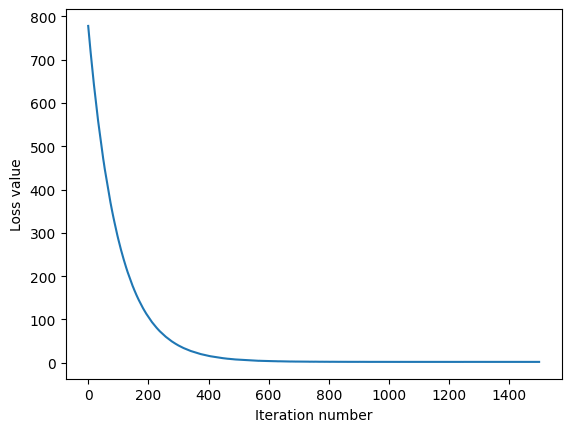

In [211]:
import time

softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [212]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.328245
validation accuracy: 0.342000


In [213]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6, 5e-6]
regularization_strengths = [1e3, 1e4, 2.5e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        # train the classifier
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
        # evaluate on training set
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        # evaluate on validation set
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        # store the result
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        # keep track of the best validation accuracy and corresponding parameters
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.263306 val accuracy: 0.285000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.349000 val accuracy: 0.358000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.327388 val accuracy: 0.342000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.400347 val accuracy: 0.414000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.338490 val accuracy: 0.347000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.324714 val accuracy: 0.336000
lr 5.000000e-06 reg 1.000000e+03 train accuracy: 0.343388 val accuracy: 0.339000
lr 5.000000e-06 reg 1.000000e+04 train accuracy: 0.224449 val accuracy: 0.225000
lr 5.000000e-06 reg 2.500000e+04 train accuracy: 0.228224 val accuracy: 0.244000
best validation accuracy achieved during cross-validation: 0.414000


In [214]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.392000


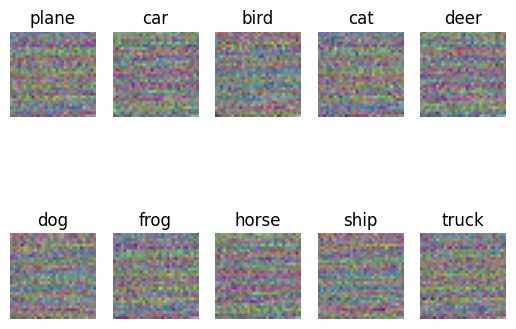

In [215]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])